# MI-ADM: home assignment 1

  * **Deadline**: 15/04/2019, -2 points for a late submission, the hard deadline is the first day of the exam period.
  * **What to submit**: Just this notebook with you code and texts, not the dataset!
  * **How to submit**: See the instructions at https://courses.fit.cvut.cz/MI-ADM/tutorials/index.html.
  
Generally speaking, the goal of this assignment is to use **decision trees and related methods (boosted trees, random forests) for the regression problem**.

What to do:
  * Study the data from `house-prices.csv` (see also `house-prices_description.txt`) and prepare them for application of the algorithms (decision tree, random forest, XGBoost).
  * Treat the missing values and nominal/ordinal variables reasonably; experiment with various approaches.
  * Try to replace the continuous features with some discrete ones (indicator variables, dummy variables, binning, ...). 
  * Tune some reasonably selected hyperparameters (using cross-validation or just a validation set) and measure the results using *Root mean squared logarithmic error (RMSLE)*.

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import GridSearchCV

%matplotlib inline

plt.rc('figure', figsize=(8,8))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [240]:
# XGboost generates warning because of deprecated function in Pandas
import warnings
warnings.filterwarnings('ignore')

### Read the Dataset

In [241]:
df = pd.read_csv('house-prices.csv')

In [242]:
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice
0   1          60       RL         65.0     8450   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2003          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace       196.0        Gd        TA      PConc       Gd       TA           No          GLQ         706          Unf           0        150          856    GasA        Ex          Y      SBrkr       856       854             0       1710             1             0         2         1             3             1          Gd             8        Typ           0         NaN     Attchd       2003.0          RFn           2         548         TA         TA          Y           0           61              0          0            0         0    NaN   NaN         NaN        0       2    2008       WD        Normal     208500
1   2          20       RL         80.0     9600   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl      Veenker      Feedr       Norm     1Fam     1Story            6            8       1976          1976     Gable  CompShg     MetalSd     MetalSd       None         0.0        TA        TA     CBlock       Gd       TA           Gd          ALQ         978          Unf           0        284         1262    GasA        Ex          Y      SBrkr      1262         0             0       1262             0             1         2         0             3             1          TA             6        Typ           1          TA     Attchd       1976.0          RFn           2         460         TA         TA          Y         298            0              0          0            0         0    NaN   NaN         NaN        0       5    2007       WD        Normal     181500
2   3          60       RL         68.0    11250   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam     2Story            7            5       2001          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace       162.0        Gd        TA      PConc       Gd       TA           Mn          GLQ         486          Unf           0        434          920    GasA        Ex          Y      SBrkr       920       866             0       1786             1             0         2         1             3             1          Gd             6        Typ           1          TA     Attchd       2001.0          RFn           2         608         TA         TA          Y           0           42              0          0            0         0    NaN   NaN         NaN        0       9    2008       WD        Normal     223500
3   4          70       RL         60.0     9550   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl      Crawfor       Norm       Norm     1Fam     2Story            7            5       1915          1970     Gable  CompShg     Wd Sdng     Wd Shng       None         0.0        TA        TA     BrkTil       TA       Gd           No          ALQ         216          Unf           0        540          756   

In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

## Data Preprocessing

### Missing Values

Let's look how many missing values has each column

In [244]:
df.isnull().sum(axis=0)

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

Notice that some columns like 'PoolQC' have a higher percentage of number of missing values than the mesured ones. We can drop those columns.

In [245]:
total = df.isnull().sum()/df.isnull().count()
total = total.sort_values(ascending=False)
total.head(15)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageCond      0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
dtype: float64

Dropping TOP 5 columns with the most missing values.

In [246]:
df = df.drop(columns=total.index.to_list()[:5])

Replacing missing values with some appropriate value.

In [247]:
# seems like the if 'LotFrontage' has missing value then there is no LotFrontage
df['LotFrontage'].fillna(0, inplace=True)

df['BsmtQual'].fillna('NA', inplace=True)
df['BsmtCond'].fillna('NA', inplace=True)
df['BsmtExposure'].fillna('NA', inplace=True)
df['BsmtFinType1'].fillna('NA', inplace=True)
df['BsmtFinType2'].fillna('NA', inplace=True)

df['GarageType'].fillna('NA', inplace=True)
df['GarageYrBlt'].fillna(0, inplace=True)
df['GarageFinish'].fillna('NA', inplace=True)
df['GarageQual'].fillna('NA', inplace=True)
df['GarageCond'].fillna('NA', inplace=True)

df['Electrical'].fillna('Mix', inplace=True)

df['MasVnrType'].fillna('None', inplace=True)
df['MasVnrArea'].fillna(0, inplace=True)

### Data Types

#### Convert Objects to Categories

In [248]:
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category') 

Check out number of unique values for numeric columns.

In [249]:
df.select_dtypes(include=['int']).nunique().sort_values(ascending=True)

BsmtHalfBath        3
HalfBath            3
BsmtFullBath        4
Fireplaces          4
FullBath            4
KitchenAbvGr        4
GarageCars          5
YrSold              5
PoolArea            8
BedroomAbvGr        8
OverallCond         9
OverallQual        10
TotRmsAbvGrd       12
MoSold             12
MSSubClass         15
3SsnPorch          20
MiscVal            21
LowQualFinSF       24
YearRemodAdd       61
ScreenPorch        76
YearBuilt         112
EnclosedPorch     120
BsmtFinSF2        144
OpenPorchSF       202
WoodDeckSF        274
2ndFlrSF          417
GarageArea        441
BsmtFinSF1        637
SalePrice         663
TotalBsmtSF       721
1stFlrSF          753
BsmtUnfSF         780
GrLivArea         861
LotArea          1073
Id               1460
dtype: int64

OverallCond, OverallCond, YrSold and MoSold seems like columns which can be convert to categorical type

In [250]:
df['OverallCond'] = df['OverallCond'].astype('category')
df['OverallQual'] = df['OverallQual'].astype('category')

df['YrSold'] = df['YrSold'].astype('category')
df['MoSold'] = df['MoSold'].astype('category')

All the rest of objects turn to categorical dtype.

In [251]:
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category') 

#### Dummy Variables

In [252]:
df_dummy = pd.get_dummies(df)

In [254]:
df_dummy.head()

Id  MSSubClass  LotFrontage  LotArea  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  SalePrice  MSZoning_C (all)  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Grvl  Street_Pave  LotShape_IR1  LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_Bnk  LandContour_HLS  LandContour_Low  LandContour_Lvl  Utilities_AllPub  Utilities_NoSeWa  LotConfig_Corner  LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  LotConfig_Inside  LandSlope_Gtl  LandSlope_Mod  LandSlope_Sev  Neighborhood_Blmngtn  Neighborhood_Blueste  Neighborhood_BrDale  Neighborhood_BrkSide  Neighborhood_ClearCr  Neighborhood_CollgCr  Neighborhood_Crawfor  Neighborhood_Edwards  Neighborhood_Gilbert  \
0   1          60         65.0     8450       2003          2003       196.0         706           0        150          856       856       854             0       1710             1             0         2         1             3             1             8           0       2003.0           2         548           0           61              0          0            0         0        0     208500                 0            0            0            1            0            0            1             0             0             0             1                0                0                0                1                 1                 0                 0                  0              0              0                 1              1              0              0                     0                     0                    0                     0                     0                     1                     0                     0                     0   
1   2          20         80.0     9600       1976          1976         0.0         978           0        284         1262      1262         0             0       1262             0             1         2         0             3             1             6           1       1976.0           2         460         298            0              0          0            0         0        0     181500                 0            0            0            1            0            0            1             0             0             0             1                0                0                0                1                 1                 0                 0                  0              1              0                 0              1              0              0                     0                     0                    0                     0                     0                     0                     0                     0                     0   
2   3          60         68.0    11250       2001          2002       162.0         486           0        434          920       920       866             0       1786             1             0         2         1             3             1             6           1       2001.0           2         608           0           42              0          0            0         0        0     223500                 0            0            0            1            0            0            1             1             0             0             0                0                0                0                1                 1                 0                 0                  0              0              0                 1              1              0              0                     0                     0                    0                     0                     0                     1                     0                     0                     0   
3   4          70         60.0     9550       1

#### Encode Categorical columns

In [255]:
object_columns = df.select_dtypes('category').columns
for col in object_columns:
    df[col] = df[col].cat.codes

### Feature Selection


Drop features with low given infromation 

In [256]:
len(df[df['Utilities'] > 0])

1

In [257]:
df.drop(columns=['Utilities'], inplace=True)

## Classification

#### Prepare Train, Test and Validation Dataset

In [273]:
from sklearn.model_selection import train_test_split

x_train_dummy, x_test_dummy, y_train_dummy, y_test_dummy = train_test_split(df.drop(columns=['SalePrice']), df['SalePrice'], test_size=0.2, random_state=42)

x_train_dummy, x_val_dummy, y_train_dummy, y_val_dummy = train_test_split(x_train_dummy, y_train_dummy, test_size=0.2, random_state=42)


x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['SalePrice']), df['SalePrice'], test_size=0.2, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

Root mean squared logaritmic error

In [274]:
def rmsle(regressor, x, y):
    return np.sqrt(mean_squared_error(regressor.predict(x), np.log(y)))

Helper function for plotting hyperparam progress

In [275]:
def plot_hyperparam_progress(hyperparams, train, test, val, hyperparam_name, model_name):
    plt.plot(hyperparams, train, '-o')
    plt.plot(hyperparams, test, '-o')
    plt.plot(hyperparams, val, '-o')

    plt.title(f'{model_name}\'s {hyperparam_name} in respect to RMSLE')
    plt.xlabel(hyperparam_name)
    plt.ylabel('RMSLE')
    plt.legend(['train', 'test', 'val'])

    plt.show()

Greedy search for best hyperparameters combination

In [276]:
def find_best_hyperparams(regressor, params, x_train, y_train):
    
    grid_search = GridSearchCV(estimator=xgbt, param_grid=hyperparams)
    
    grid_search.fit(x_train, np.log(y_train))

    print(f'Best score: {grid_search.best_score_}')

    print("Set hyperparameters:")
    best_parameters=grid_search.best_estimator_.get_params()
    for param_name in sorted(hyperparams.keys()):
        print(f'\t{param_name} : {best_parameters[param_name]}')
    
    return grid_search.best_estimator_

## Decision Tree

Baseline performance of the desicion model.   

Comparing performance of preprocessed dataset with dummy variable and regular one with just encoded categorical variables.

In [282]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, accuracy_score

drt = DecisionTreeRegressor(max_depth=20)
drt.fit(x_train, np.log(y_train))

print('Root mean squared logarithmic error (train):', rmsle(drt, x_train, y_train))
print('Root mean squared logarithmic error (test):', rmsle(drt, x_test, y_test))
print('Root mean squared logarithmic error (val):', rmsle(drt, x_val, y_val))

print('')

drt.fit(x_train_dummy, np.log(y_train_dummy))
print('Root mean squared logarithmic error (train dummy):', rmsle(drt, x_train_dummy, y_train_dummy))
print('Root mean squared logarithmic error (test dummy):', rmsle(drt, x_test_dummy, y_test_dummy))
print('Root mean squared logarithmic error (val dummy):', rmsle(drt, x_val_dummy, y_val_dummy))

Root mean squared logarithmic error (train): 4.562145536009896e-05
Root mean squared logarithmic error (test): 0.19610107422723233
Root mean squared logarithmic error (val): 0.2051177715507784

Root mean squared logarithmic error (train dummy): 4.562145536009896e-05
Root mean squared logarithmic error (test dummy): 0.19306318509712386
Root mean squared logarithmic error (val dummy): 0.2215808351835347


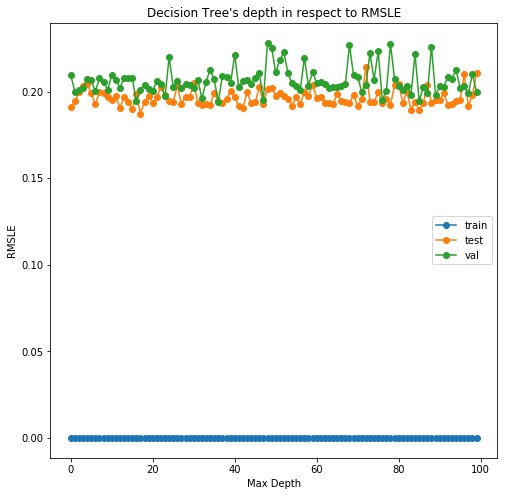

In [284]:
start_depth = 0
max_depth = 100

train = []
test = []
val = []

for i in range(start_depth, max_depth):

    drt = DecisionTreeRegressor(max_depth=70)
    drt.fit(x_train_dummy, np.log(y_train_dummy))
    
    train.append(rmsle(drt, x_train, y_train))
    test.append(rmsle(drt, x_test, y_test))
    val.append(rmsle(drt, x_val, y_val))

plt.plot(train, '-o')
plt.plot(test, '-o')
plt.plot(val, '-o')

plt.title('Decision Tree\'s depth in respect to RMSLE')
plt.xlabel('Max Depth')
plt.ylabel('RMSLE')
plt.legend(['train', 'test', 'val'])

plt.show()

Hyperparameter for max depth of Desicion Tree does not really affect RMSLE of test set. We can choose some lower depth of the desicion tree so we can save some computations.

We suspect that this model will have the worst performance from the used ones.

## Random Forest

In [285]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(max_depth=70)
rfr.fit(x_train, np.log(y_train))

print('Root mean squared logarithmic error (train):', rmsle(rfr, x_train, y_train))
print('Root mean squared logarithmic error (test):', rmsle(rfr, x_test, y_test))
print('Root mean squared logarithmic error (val):', rmsle(rfr, x_val, y_val))

print('')

rfr.fit(x_train_dummy, np.log(y_train_dummy))
print('Root mean squared logarithmic error (train dummy):', rmsle(drt, x_train_dummy, y_train_dummy))
print('Root mean squared logarithmic error (test dummy):', rmsle(drt, x_test_dummy, y_test_dummy))
print('Root mean squared logarithmic error (val dummy):', rmsle(drt, x_val_dummy, y_val_dummy))

Root mean squared logarithmic error (train): 0.06831142662840803
Root mean squared logarithmic error (test): 0.15675260146839834
Root mean squared logarithmic error (val): 0.15510057014450657

Root mean squared logarithmic error (train dummy): 2.4728152679736205e-05
Root mean squared logarithmic error (test dummy): 0.21082842498978085
Root mean squared logarithmic error (val dummy): 0.19975787238458428


Random Forrest model has clearly batter performance on encoded dataset without dummy variables and it's also better model then Desicion Tree.

#### Hyperparameter - Max Depth

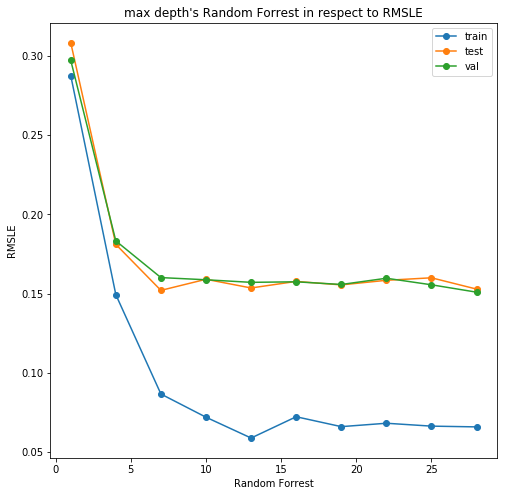

In [212]:
start_depth = 1
max_depth = 30

depth = []
train = []
test = []
val = []

for i in range(start_depth, max_depth, 3):
    
    rfr = RandomForestRegressor(max_depth=i)
    rfr.fit(x_train, np.log(y_train))
    
    train.append(rmsle(rfr, x_train, y_train))
    test.append(rmsle(rfr, x_test, y_test))
    val.append(rmsle(rfr, x_val, y_val))
    depth.append(i)

plot_hyperparam_progress(depth, train, test, val, 'Random Forrest', 'max depth')

#### Hyperparameter - Number of Estimators

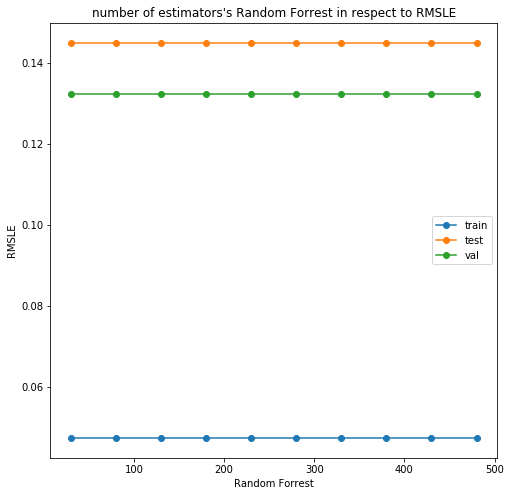

In [217]:
start_num_estimators = 30
max_num_estimators = 500

num_estimators = []
train = []
test = []
val = []

for i in range(start_num_estimators, max_num_estimators, 50):

    rfr = RandomForestRegressor(max_depth=12, n_estimators=i)
    rfr.fit(x_train, np.log(y_train))
    
    train.append(rmsle(xgbt, x_train, y_train))
    test.append(rmsle(xgbt, x_test, y_test))
    val.append(rmsle(xgbt, x_val, y_val))
    num_estimators.append(i)
    
plot_hyperparam_progress(num_estimators, train, test, val, 'Random Forrest', 'number of estimators')

### Search best hyperparameter combination

In [231]:
hyperparams = {'n_estimators': [5, 10, 25, 50, 100, 150, 200],
              'max_depth': list(range(1, 50, 3))}

In [232]:
estimator = find_best_hyperparams(RandomForestRegressor(), hyperparams, x_train, y_train)

print('Root mean squared logarithmic error (train):', rmsle(estimator, x_train, y_train))
print('Root mean squared logarithmic error (test):', rmsle(estimator, x_test, y_test))
print('Root mean squared logarithmic error (val):', rmsle(estimator, x_val, y_val))

Best score: 0.8747484885405934
Set hyperparameters:
	max_depth : 4
	n_estimators : 150
Root mean squared logarithmic error (train): 0.06225612654603728
Root mean squared logarithmic error (test): 0.1412086806909294
Root mean squared logarithmic error (val): 0.13239627659994044


Dataset with dummy variables

In [288]:
estimator = find_best_hyperparams(RandomForestRegressor(), hyperparams, x_train_dummy, y_train_dummy)

print('Root mean squared logarithmic error (train):', rmsle(estimator, x_train_dummy, y_train_dummy))
print('Root mean squared logarithmic error (test):', rmsle(estimator, x_test_dummy, y_test_dummy))
print('Root mean squared logarithmic error (val):', rmsle(estimator, x_val_dummy, y_val_dummy))

Best score: 0.8812016109182987
Set hyperparameters:
	gamma : 0
	learning_rate : 0.1
	max_depth : 5
	n_estimators : 200
Root mean squared logarithmic error (train): 0.023584792811803677
Root mean squared logarithmic error (test): 0.14162101810705313
Root mean squared logarithmic error (val): 0.1329451031905706


### XGBoost

In [182]:
import xgboost

xgbt = xgboost.sklearn.XGBRegressor(max_depth=3, n_estimators=1000, verbosity=1, objective='reg:linear', gamma=0.1, learning_rate=0.1)

xgbt.fit(x_train, np.log(y_train))


print('Root mean squared logarithmic error (train):', rmsle(xgbt, x_train, y_train))
print('Root mean squared logarithmic error (test):', rmsle(xgbt, x_test, y_test))
print('Root mean squared logarithmic error (val):', rmsle(xgbt, x_val, y_val))

Root mean squared logarithmic error (train): 0.09092210628063248
Root mean squared logarithmic error (test): 0.14449348038721338
Root mean squared logarithmic error (val): 0.13987189998624444


#### Hyperparameter - MaxDepth

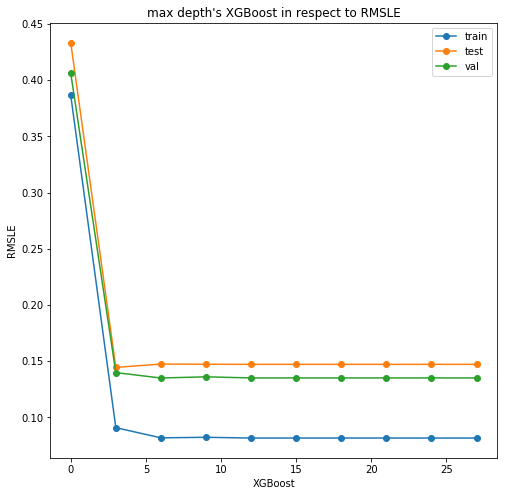

In [187]:
start_depth = 0
max_depth = 30

depth = []
train = []
test = []
val = []

for i in range(start_depth, max_depth, 3):

    xgbt = xgboost.sklearn.XGBRegressor(max_depth=i, n_estimators=500, verbosity=1, objective='reg:linear', gamma=0.1, learning_rate=0.1)
    xgbt.fit(x_train, np.log(y_train))
    
    train.append(rmsle(xgbt, x_train, y_train))
    test.append(rmsle(xgbt, x_test, y_test))
    val.append(rmsle(xgbt, x_val, y_val))
    depth.append(i)

plot_hyperparam_progress(depth, train, test, val, 'XGBoost', 'max depth')

#### Hyperparameter - Number of estimators

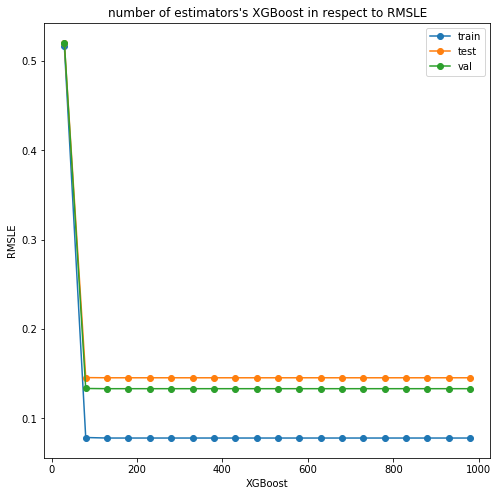

In [189]:
start_num_estimators = 30
max_num_estimators = 1000

num_estimators = []
train = []
test = []
val = []

for i in range(start_num_estimators, max_num_estimators, 50):

    xgbt = xgboost.sklearn.XGBRegressor(max_depth=10, n_estimators=i, verbosity=1, objective='reg:linear', gamma=0.1, learning_rate=0.1)
    xgbt.fit(x_train, np.log(y_train))
    
    train.append(rmsle(xgbt, x_train, y_train))
    test.append(rmsle(xgbt, x_test, y_test))
    val.append(rmsle(xgbt, x_val, y_val))
    num_estimators.append(i)
    
plot_hyperparam_progress(num_estimators, train, test, val, 'XGBoost', 'number of estimators')

#### Hyperparameter - Learning Rate

1
0.5
0.3
0.2
0.1
0.075
0.05
0.025


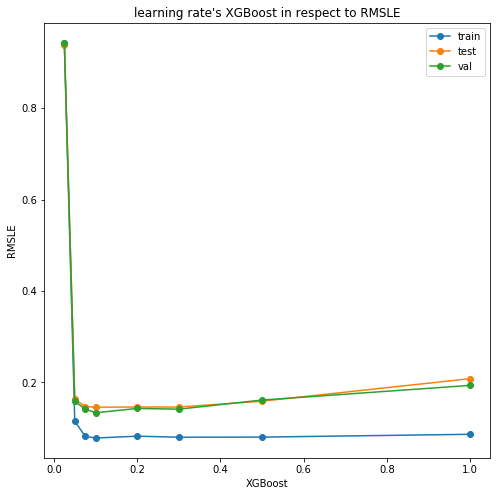

0.1

In [206]:
learning_rates = [1, 0.5, 0.3, 0.2, 0.1, 0.075, 0.05, 0.025]

train = []
test = []
val = []

for learning_rate in learning_rates:
    
    print(learning_rate)
    
    xgbt = xgboost.sklearn.XGBRegressor(max_depth=10, n_estimators=100, verbosity=1, objective='reg:linear', gamma=0.1, learning_rate=learning_rate)
    xgbt.fit(x_train, np.log(y_train))
    
    train.append(rmsle(xgbt, x_train, y_train))
    test.append(rmsle(xgbt, x_test, y_test))
    val.append(rmsle(xgbt, x_val, y_val))
    
plot_hyperparam_progress(learning_rates, train, test, val, 'XGBoost', 'learning rate')

learning_rates[int(np.argmin(test))]

#### Hyperparameter - Gamma

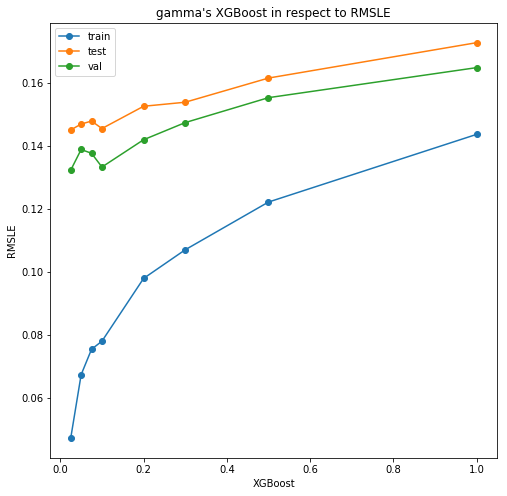

0.025

In [210]:
gammas = [1, 0.5, 0.3, 0.2, 0.1, 0.075, 0.05, 0.025]

train = []
test = []
val = []

for gamma in gammas:
    
    xgbt = xgboost.sklearn.XGBRegressor(max_depth=10, n_estimators=100, verbosity=1, objective='reg:linear', gamma=gamma, learning_rate=0.1)
    xgbt.fit(x_train, np.log(y_train))
    
    train.append(rmsle(xgbt, x_train, y_train))
    test.append(rmsle(xgbt, x_test, y_test))
    val.append(rmsle(xgbt, x_val, y_val))
    
plot_hyperparam_progress(learning_rates, train, test, val, 'XGBoost', 'gamma')

gammas[int(np.argmin(test))]

#### Search Hyperparam space for XGBoost

The previous graphs gave us little intuition how to pick the hyperparameters. 
Next we are going to look for the best combination.

In [234]:
hyperparams = {'n_estimators': [3, 5, 10, 50, 100, 150, 200],
              'max_depth': [3, 5, 7],
              'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
              'gamma':[0.025, 0.05, 0.075, 0.1, 0.2]}

In [235]:
estimator = find_best_hyperparams(xgboost.sklearn.XGBRegressor(), hyperparams, x_train, y_train)

print('Root mean squared logarithmic error (train):', rmsle(estimator, x_train, y_train))
print('Root mean squared logarithmic error (test):', rmsle(estimator, x_test, y_test))
print('Root mean squared logarithmic error (val):', rmsle(estimator, x_val, y_val))

Best score: 0.8812016109182987
Set hyperparameters:
	gamma : 0
	learning_rate : 0.1
	max_depth : 5
	n_estimators : 200
Root mean squared logarithmic error (train): 0.023584792811803677
Root mean squared logarithmic error (test): 0.14162101810705313
Root mean squared logarithmic error (val): 0.1329451031905706


Dataset with dummy variables

In [ ]:
estimator = find_best_hyperparams(xgboost.sklearn.XGBRegressor(), hyperparams, x_train_dummy, y_train_dummy)

print('Root mean squared logarithmic error (train):', rmsle(estimator, x_train_dummy, y_train_dummy))
print('Root mean squared logarithmic error (test):', rmsle(estimator, x_test_dummy, y_test_dummy))
print('Root mean squared logarithmic error (val):', rmsle(estimator, x_val_dummy, y_val_dummy))

## Conclusion

We have preprocessed historic data of house sales. The goal was to predict value of a house based on given features, which is regression problem and we appliyed Desicion Trees, Random Forrest and XGboost algorithms. We observed how hyperparameters of each model affects RMSLE (Root Mean Squared Logaritmic Error) and mesured that from given the models XGBoost had the smallest error on train and valid dataset.

We can improve the performance by applying better feature selection (homework from MI-PDD) a standardization.